In [1]:
import unittest
import os
import sys
import numpy as np
import igl
import time
import matplotlib.pyplot as plt
import importlib

import rainbow.cuda.geometry.grid3 as CUDAGRID
import rainbow.geometry.grid3 as GRID
import rainbow.geometry.volume_mesh as VM
from numba import cuda

from tqdm import tqdm
import rainbow.math.vector3 as V3
import rainbow.simulators.prox_soft_bodies.api as API
import rainbow.simulators.prox_soft_bodies.solver as SOLVER

importlib.reload(API)
importlib.reload(SOLVER)
importlib.reload(CUDAGRID)

<module 'rainbow.cuda.geometry.grid3' from '/home/qbp758/dev/RAINBOW/python/rainbow/cuda/geometry/grid3.py'>

In [2]:

def get_gradient_on_gpu(grid, points):
    results_gpu = cuda.device_array((points.shape[0], 3), dtype=np.int32)
    threads_per_block = 256
    blocks_per_grid = (points.shape[0] + threads_per_block - 1) // threads_per_block
    CUDAGRID.get_gradient_kernel[blocks_per_grid, threads_per_block](points, grid.min_coord, grid.spacing, grid.I, grid.J, grid.K, grid.values, results_gpu)
    return results_gpu.copy_to_host()

def get_gradient_on_cpu(grid, points):
    results_cpu = np.zeros((points.shape[0], 3), dtype=np.int32)
    for i in range(points.shape[0]):
        p = points[i]
        results_cpu[i] = GRID.get_gradient(grid, p)
    return results_cpu

def plot_profile(X, cpu_times, gpu_times, xlabel, title='Execution Time Comparison: CPU vs GPU'):
    plt.figure(figsize=(10, 6))
    plt.plot(X, cpu_times, '-o', label='CPU')
    plt.plot(X, gpu_times, '-o', label='GPU')
    plt.xlabel(xlabel)
    plt.ylabel('Execution Time (seconds)')
    plt.title(title)
    plt.yscale('log')
    plt.xscale('log')
    plt.legend()
    plt.grid(True, which="both", ls="--", c='0.7')
    plt.show()


In [15]:
def get_gradient_profile_by_points():

    numbers = [100, 1000, 10000, 100000, 1000000, 10000000]
    gpu_times = []
    cpu_times = []
    engine = API.create_engine()
    V_beam, T_beam = VM.create_beam(20, 20, 20, 100.0, 100.0, 100.0)
    API.create_soft_body(engine, 'beam', V_beam, T_beam)
    body = engine.bodies['beam']
    grid = body.grid
    for number in numbers:
        points = np.random.rand(number, 3) * 10
        # record time of gpu computing
        start_time_gpu = time.time()
        gpu_results = get_gradient_on_gpu(grid, points)
        end_time_gpu = time.time()
        gpu_times.append(end_time_gpu - start_time_gpu)

        # record time of cpu computing
        start_time_cpu = time.time()
        cpu_results = get_gradient_on_cpu(grid, points)
        end_time_cpu = time.time()
        cpu_times.append(end_time_cpu - start_time_cpu)

        #valid check
        if (np.all(cpu_results == gpu_results)):
            print("valid")
        else:
            print("invalid")

    plot_profile(numbers, cpu_times, gpu_times, 'Number of Points to Compute Gradient')
    return numbers, cpu_times, gpu_times


/home/qbp758/anaconda3/envs/sim/lib/python3.9/site-packages/numba/cuda/cudadrv/devicearray.py:886: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


valid
valid
valid
valid
valid
valid


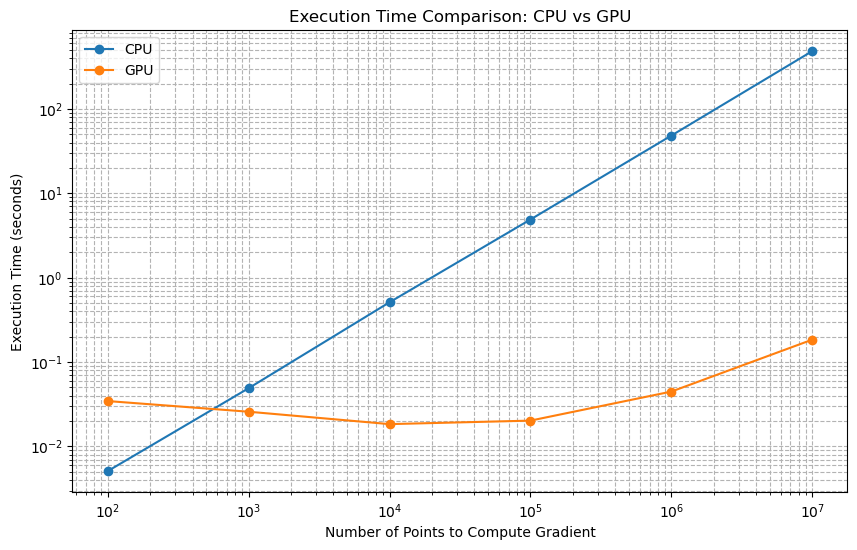

In [16]:
X, y1, y2 = get_gradient_profile_by_points()